## ИАД: Введение в анализ данных – 2021

## Семинар 13: Случайный лес

In [7]:
!pip install xgboost
!pip install mlxtend

You should consider upgrading via the 'c:\users\air23\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\air23\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


### 1. Bias-Variance decomposition

Вспомним, что функцию потерь в задачах регрессии или классификации можно разложить на три компоненты: смещение (bias), дисперсию (variance) и шум (noise). Эти компоненты позволяют описать сложность алгоритма, альтернативно сравнению ошибок на тренировочной и тестовой выборках. Хотя такое разложение можно построить для произвольной функции потерь, наиболее просто (и классически) оно строится для среднеквадратичной функции в задаче регрессии, что мы и рассмотрим ниже. 

Пусть $(X, y)$ – некоторая выборка. Обучим интересующий нас алгоритм на этой выборке и сделаем предсказания на ней. Обозначим предсказания как $\hat{y}$. Тогда 

$$
\mathrm{bias} := \mathbb{E}(\hat{y}) - y.
$$

$$
\mathrm{variance} := \mathbb{E}[\mathbb{E}(\hat{y}) - \hat{y}]^2
$$

$$
\mathrm{noise} := \mathbb{E}[y - \mathbb{E}(y)]^2
$$

Ожидаемую среднеквадратичную ошибку на тренировочной выборке можно разложить как

$$
\mathrm{E}[y - \hat{y}]^2 = \mathrm{bias}^2 + \mathrm{variance} + \mathrm{noise}.
$$

**Задание для самых смелых:** покажите, что это разложение корректно. Проверьте себя [здесь](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture08-ensembles.pdf).

**Техническое замечание:** все математические ожидания в разложении выше берутся по объектам тренировочной выборки, то есть это разложение верно для среднеквадратичной ошибки на тренировочной выборке, которую иногда называют MSE for estimator. Тем не менее, нам интересна и величина ошибки на ненаблюдаемых данных, которую иногда называют MSE for predictor. В этом случае математическое ожидание ошибки следует брать по ненаблюдаемым объектам. Для решения этой проблемы зачастую предполагается, что тренировочная и тестовая выборка имеют одинаковое распределение, и математическое ожидание берётся по всевозможным вариациям тренировочной выборки. Суть разложения при этом не изменится, однако запись его станет более громоздкой. Посмотреть на это можно [здесь](https://towardsdatascience.com/mse-and-bias-variance-decomposition-77449dd2ff55). 

Заметим, что так как на практике мы считаем оценки математических ожиданий и зачастую имеем доступ к тестовой выборке, то проблем с расчётом **оценок** MSE for estimator и MSE for predictor не возникает.

Разберёмся с интерпретацией компонент. 

- $\mathrm{Bias}$ – показывает отклонение среднего ответа алгоритма от ответа идеального алгоритма. $\mathrm{Bias}$ отражает ошибку модели, возникающую из-за простоты модели. Высокое смещение обычно является показателем того, что модель недообучена.


- $\mathrm{Variance}$ – показывает разброс ответов алгоритмов относительно среднего ответа алгоритма. Показывает, насколько сильно небольшие изменения в обучающей выборке скажутся на предсказаниях алгоритма. $\mathrm{Variance}$ отражает ошибку модели, возникающую из-за чрезмерной сложности модели. Высокая дисперсия обычно является показателем того, что модель переобучена.


- $\mathrm{Noise}$ – ошибка идеального классификатора, естественный неустранимый шум в данных. 

Посмотрим наглядно на примере полиномиальной регрессии.

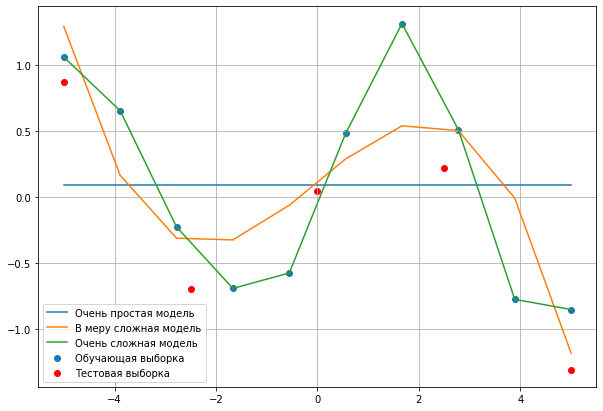

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Выборка
np.random.seed(42)
N = 10
X = np.linspace(-5, 5, N).reshape(-1, 1)
y = np.sin(X) + np.random.normal(0, 0.2, size = N).reshape(-1, 1)

X_test = np.linspace(-5, 5, N // 2).reshape(-1, 1)
y_test = np.sin(X_test) + np.random.normal(0, 0.2, size = N // 2).reshape(-1, 1)

# Очень простая модель (регрессия на константу)
too_simple_model_predictions = np.mean(y) * np.ones_like(y)

# В меру сложная модель
X_ok = np.hstack([X, X ** 2, X ** 3])
ok_model = LinearRegression()
ok_model.fit(X_ok, y)
ok_model_predictions = ok_model.predict(X_ok)

# Очень сложная модель
X_compl = np.hstack([X, X ** 2, X ** 3, X ** 4, X ** 5, X ** 6, X ** 7, X ** 8, X ** 9, X ** 10])
compl_model = LinearRegression()
compl_model.fit(X_compl, y)
compl_model_predictions = compl_model.predict(X_compl)

plt.figure(figsize = (10, 7))

plt.scatter(X, y, label = 'Обучающая выборка')
plt.scatter(X_test, y_test, c = 'r', label = 'Тестовая выборка')
plt.plot(X, too_simple_model_predictions, label = 'Очень простая модель')
plt.plot(X, ok_model_predictions, label = 'В меру сложная модель')
plt.plot(X, compl_model_predictions, label = 'Очень сложная модель')
plt.grid()
plt.legend();

- Очень простая модель имеет большое смещение (bias), но малую (нулевую) дисперсию (variance). Модель явно недообучена.

- В меру сложная модель имеет небольшое смещение (bias) и небольшую дисперсию (variance).

- Очень сложная модель имеет небольшое смещение (bias), но большую дисперсию (variance). Модель явно переобучена.

**Задание:** пользуясь определениями выше, объясните, почему это так.

**Задание:** прокомментируйте величину смещения и дисперсии для следующих моделей:

1. Линейная регрессия, обучаемая на большой выборке без выбросов и линейно зависимых признаков, в которой признаки сильно коррелируют с целевой переменной.
2. Решающее дерево, которое строится до тех пор, пока в листах не окажется по одному объекту.
3. Логистическая регрессия, относящая все точки к одному классу.

### 1.A. Bias-Variance tradeoff

Из описания выше можно заметить, что при обучении моделей возникает выбор между смещением и дисперсией: недообученная модель имеет низкую дисперсию, но высокое смещение, а переобученная – низкое смещение, но высокую дисперсию. Этот выбор можно отобразить на картинке ([источник](https://www.bradyneal.com/bias-variance-tradeoff-textbooks-update)). Здесь Total Error – ошибка на тестовой выборке (generalization error).

![](https://www.bradyneal.com/img/bias-variance/fortmann-roe-bias-variance.png)

Вывод из неё очевиден: строить следует оптимальные по сложности модели. 

Возникает ли такой выбор при обучении любой модели? Последние исследования показывают, что поведение ошибки при обучении некоторых (современных) моделей не соответствует такой U-образной форме. Например, было показано, что ошибка на тестовой выборке продолжает убывать при расширении (увеличении числа слоёв) нейронных сетей:

<img src="https://www.bradyneal.com/img/bias-variance/neyshabur.jpg" alt="drawing" width="400"/>

В таких моделях поведение ошибки приобретает сложный вид:


<img src="https://www.bradyneal.com/img/bias-variance/double_descent.jpg" alt="drawing" width="800"/>

### 3. От деревьев к случайному лесу

#### 3.1 Решающее дерево

Мотивацию построения алгоритма случайного леса (Random Forest) удобно рассматривать в терминах смещения и дисперсии. Начнём с построения решающего дерева.

In [8]:
# Пример отсюда: http://rasbt.github.io/mlxtend/user_guide/evaluate/bias_variance_decomp/

from sklearn.model_selection import train_test_split
from mlxtend.data import boston_housing_data

X, y = boston_housing_data()
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 123,
                                                    shuffle = True)

In [13]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# TODO: обучите решающее дерево без ограничений на тренировочной выборке
dt = DecisionTreeRegressor(random_state = 123)
dt.fit(X_train, y_train)

# TODO: рассчитайте MSE на тренировочной и тестовой выборках
print('MSE train: %f' % mean_squared_error(y_train, dt.predict(X_train)))
print('MSE test: %f' % mean_squared_error(y_test, dt.predict(X_test)))


MSE train: 0.000000
MSE test: 20.107368


In [14]:
from mlxtend.evaluate import bias_variance_decomp

# TODO: воспользуйтесь функцией bias_variance_decomp и выведите среднее смещение и среднюю дисперсию модели
# на тестовой выборке

bias_variance_decomp(dt, X_train, y_train, X_test, y_test,
                     loss = 'mse', random_seed=123)

(31.536008881578947, 14.095801179276307, 17.440207702302633)

Как мы обсуждали на предыдущем семинаре, такое дерево окажется сильно переобученным (высокая дисперсия и низкое смещение). Постараемся исправить это. На лекции мы обсуждали, что один из способов борьбы с переобучением – построение композиций моделей. На этом семинаре мы рассмотрим построение композиций при помощи бэггинга.

#### 3.2 Бэггинг

Вспомним суть алгоритма:

1. Обучаем много деревьев на бутстрапированных подвыборках исходной выборки независимо друг от друга. Бутстрапированную подвыборку строим при помощи выбора $N$ (размер исходной выборки) наблюдений из исходной выборки с возвращением. 

2. Усредняем предсказания всех моделей (например, берём арифметическое среднее). 

Можно показать, что модель, построенная при помощи бэггинга, будет иметь **то же смещение**, что и у отдельных деревьев, но значительно **меньшую дисперсию** (при выполнении некоторых условий). 

In [15]:
from sklearn.ensemble import BaggingRegressor

base_tree = DecisionTreeRegressor(random_state = 123)

# TODO: обучите бэггинг с 20 деревьями, каждое из которых строится без ограничений
bagging = BaggingRegressor(base_tree, n_estimators=20, random_state=123)

# TODO: выведите среднее смещение и среднюю дисперсию модели на тестовой выборке

bias_variance_decomp(bagging, X_train, y_train, X_test, y_test,
                     loss = 'mse', random_seed=123)

(19.52460576973684, 15.698490362598681, 3.8261154071381576)

Как мы видим, по сравнению с единичным деревом смещение практически не изменилось, но дисперсия уменьшилась в несколько раз!

Посмотрим, как это отразилось на среднеквадратичной ошибке.

In [16]:
# TODO: рассчитайте MSE на тренировочной и тестовой выборках для бэггинга

print('MSE train: %f' % mean_squared_error(y_train, bagging.predict(X_train)))
print('MSE test: %f' % mean_squared_error(y_test, bagging.predict(X_test)))

MSE train: 3.921139
MSE test: 16.830003


Среднеквадратичная ошибка на тренировочной выборке больше не равна 0, а на тестовой – уменьшилась, что говорит о том, что мы успешно победили переобучение единичного решающего дерева. 

Можем ли мы снизить переобучение ещё сильнее? Можем!

#### 3.3 Случайный лес

При построении каждого дерева в бэггинге в ходе создания очередного узла будем выбирать случайный набор признаков, на основе которых производится разбиение. В результате такой процедуры мы уменьшим корреляцию между деревьями, за счёт чего снизим дисперсию итоговой модели. Такой алгоритм назвывается **случайным лесом** (Random Forest). 

По сравнению с единичным деревом к параметрам случайного леса добавляются:
- `max_features` – число признаков, на основе которых проводятся разбиения при построении дерева.

- `n_estimators` – число деревьев. 

Естественно, все параметры, относящиеся к единичному дереву, сохраняются для случайного леса.

In [19]:
from sklearn.ensemble import RandomForestRegressor

# TODO: обучите случайный лес с 20 деревьями, каждое из которых строится без ограничений
rf = RandomForestRegressor(n_estimators=20, random_state=123)
# TODO: выведите среднее смещение и среднюю дисперсию модели на тестовой выборке
_, bias, var = bias_variance_decomp(rf, X_train, y_train, X_test, y_test,
                     loss = 'mse', random_seed=123)
print(bias, var)
# TODO: рассчитайте MSE на тренировочной и тестовой выборках для случайного леса
print('MSE train: %f' % mean_squared_error(y_train, rf.predict(X_train)))
print('MSE test: %f' % mean_squared_error(y_test, rf.predict(X_test)))


15.645907080711353 3.8086950960978614
MSE train: 4.073119
MSE test: 15.972788


Как мы видим, по сравнению с бэггингом смещение вновь осталось практически неизменным, а дисперсия немного уменьшилась. Конечно, если подобрать хорошие гиперпараметры, то получится снизить дисперсию ещё больше. 

Ошибка на тренировочной выборке увеличилась, а на тестовой – уменьшилась, что означает, что мы добились нашей цели в борьбе с переобученными деревьями!

### 4. Особенности случайного леса

#### 4.1 Число деревьев и "Случайный лес не переобучается"

В своём [блоге](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#remarks) Лео Бриман (Leo Breiman), создатель случайного леса, написал следующее:

> Random forest does not overfit. You can run as many trees as you want.

**Обратите внимание:** как говорилось на лекции, случайный лес не переобучается именно с ростом числа деревьев (за счёт совместной работы бэггинга и использования случайных подпространств), но не в принципе. Посмотрим на поведение случайного леса при росте числа деревьев.

In [20]:
X, y = boston_housing_data()
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 123,
                                                    shuffle = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

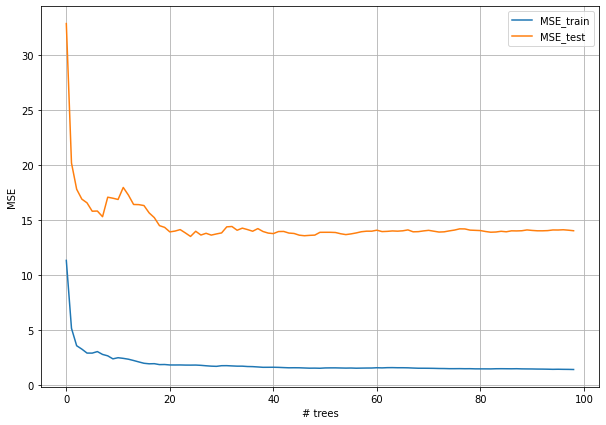

In [21]:
n_trees = 100
train_loss = []
test_loss = []

for i in range(1, n_trees):
    rf = RandomForestRegressor(n_estimators = i, random_state = 123)
    rf.fit(X_train, y_train)
    train_loss.append(mean_squared_error(y_train, rf.predict(X_train)))
    test_loss.append(mean_squared_error(y_test, rf.predict(X_test)))
    
plt.figure(figsize = (10, 7))
plt.grid()
plt.plot(train_loss, label = 'MSE_train')
plt.plot(test_loss, label = 'MSE_test')
plt.ylabel('MSE')
plt.xlabel('# trees')
plt.legend();

Как и ожидалось, по достижении некоторого числа деревьев обе ошибки практически не изменяются, то есть переобучения при росте числа деревьев не происходит.

Однако практика показывает, что при изменении какого-нибудь другого параметра на реальных данных переобучение может произойти: [пример 1](https://datascience.stackexchange.com/questions/1028/do-random-forest-overfit), [пример 2](https://mljar.com/blog/random-forest-overfitting/). Например, случайный лес с ограниченными по глубине деревьями может предсказывать более точно, чем лес без ограничений. 

В нашем же случае случайный лес, скорее, лишь страдает от регуляризации. Например, посмотрим на поведение модели при изменении максимальной глубины деревьев (поэксперементируйте с другими параметрами).

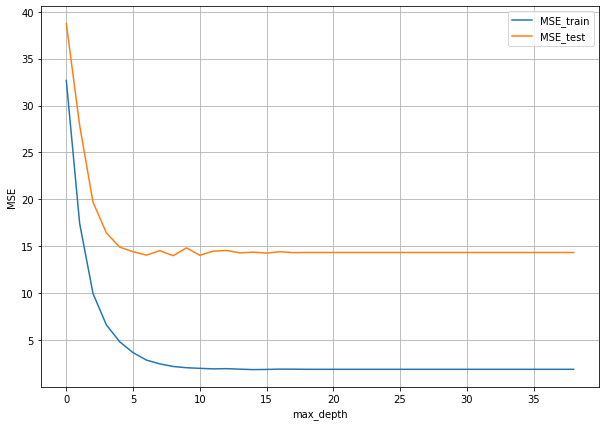

In [22]:
max_depth = 40
train_loss = []
test_loss = []

for i in range(1, max_depth):
    rf = RandomForestRegressor(n_estimators = 20, max_depth = i, random_state = 123)
    rf.fit(X_train, y_train)
    train_loss.append(mean_squared_error(y_train, rf.predict(X_train)))
    test_loss.append(mean_squared_error(y_test, rf.predict(X_test)))
    
plt.figure(figsize = (10, 7))
plt.grid()
plt.plot(train_loss, label = 'MSE_train')
plt.plot(test_loss, label = 'MSE_test')
plt.ylabel('MSE')
plt.xlabel('max_depth')
plt.legend();

Переобучение не наблюдается. Вообще же, как обычно, гиперпараметры случайного леса стоит подбирать на кросс-валидации.

#### 4.2 Out-of-bag-ошибка

Как мы обсудили выше, при построении случайного леса каждое дерево строится на бутстрапированной подвыборке, полученной из исходной обучающей выборки случайным набором с повторениями. Понятно, что некоторые наблюдения попадут в такую подвыборку несколько раз, а некоторые не войдут в неё вообще. Для каждого дерева мы можем рассмотреть объекты, которые не участвовали в обучении и использовать их для валидации.

Усреднённая ошибка на неотобранных образцах по всему случайному лесу называется **out-of-bag-ошибкой**.

In [26]:
X, y = boston_housing_data()
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 123,
                                                    shuffle = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

# oob_score_ = R2 на невиденных наблюдениях.
rf = RandomForestRegressor(n_estimators = 100, random_state = 123, oob_score = True)
rf.fit(X_train, y_train)
rf.oob_score_

0.8760889947613861

#### 4.3 Важность признаков

Как и решающие деревья, случайный лес позволяет оценивать важность признаков.

In [27]:
# Просто чтобы подгрузить названия признаков
from sklearn.datasets import load_boston
data = load_boston()

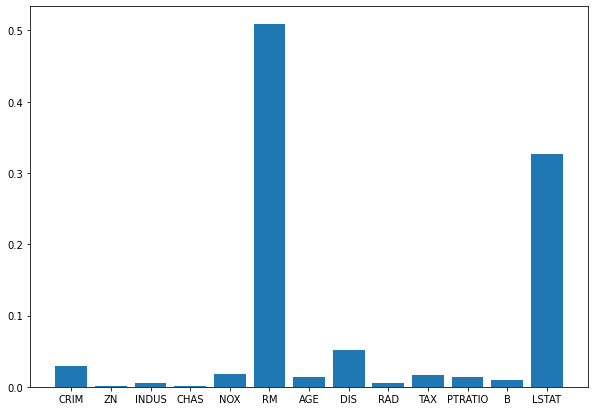

In [28]:
plt.figure(figsize = (10, 7))
plt.bar(data['feature_names'], rf.feature_importances_);

Будьте осторожны с сильно коррелирующими признаками. Посмотрим, что произойдёт с важностью, если добавить в выборку линейно зависимый признак.

In [29]:
RM_mc = (X_train[:, 5] * 2 + 3).reshape(-1, 1)
X_train_new = np.hstack((X_train, RM_mc))

In [30]:
rf.fit(X_train_new, y_train)

RandomForestRegressor(oob_score=True, random_state=123)

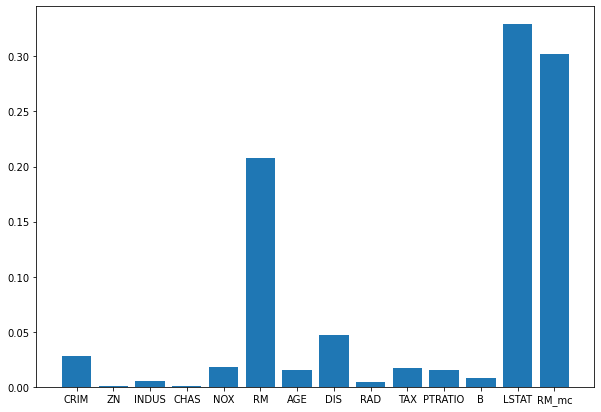

In [31]:
plt.figure(figsize = (10, 7))
names = list(data['feature_names'])
names.append('RM_mc')
plt.bar(names, rf.feature_importances_);

Важности перераспределились между линейной зависимыми признаками `RM` и `RM_mc`. Не забывайте учитывать корреляции между признаками, если вы используете этот метод для отбора признаков. Также обратите внимание на предупреждение в документации `sklearn`: не стоит использовать этот метод и для признаков, в которых есть много уникальных значений (например, категориальные признаки с небольшим числом категорий). 

### 5. Тестирование случайного леса на разных данных

Ниже представлены шаблоны для сравнения случайного леса и других моделей на данных разных типов. Проведите побольше экспериментов, используя разные модели и метрики. Попробуйте подобрать гиперпараметры случайного леса так, чтобы достичь какого-нибудь порога качества. 

**Внимание:** в этой части вам предстоит скачивать объёмные наборы данных. Не забудьте удалить их после семинара, если не планируете использовать их в дальнейшем, чтобы они не занимали лишнее место на вашем компьютере.

**! Случайный лес может обучаться достаточно долго.**

#### 5.1 Бинарная классификация на примере [Kaggle Predicting a Biological Response](https://www.kaggle.com/c/bioresponse/data?select=train.csv)

In [40]:
# Загрузка данных
!wget  -O 'kaggle_response.csv' -q 'https://www.dropbox.com/s/uha70sej5ugcrur/_train_sem09.csv?dl=1'

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [41]:
data = pd.read_csv('_train_sem09.csv')
X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import time
# TODO: обучите логистическую регрессию и случайный лес с дефолтными параметрами
# Сравните их AUC ROC на тестовой выборке
start = time.time()
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
pred_rf = rf.predict_proba(X_test)
print('RF:', time.time() - start)

start = time.time()
lr = LogisticRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict_proba(X_test)
print('RF:', time.time() - start)

RF: 1.467254638671875
RF: 0.710972785949707


c:\users\air23\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [46]:
roc_auc_score(y_test, pred_rf[:, 1])


0.880180120037639

In [47]:
roc_auc_score(y_test, pred_lr[:, 1])

0.8015532412705679

#### 5.2 Изображения на примере [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist)

In [52]:
!pip install torchvision

  Using cached torchvision-0.10.0-cp39-cp39-win_amd64.whl (920 kB)


You should consider upgrading via the 'c:\users\air23\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [53]:
# Загрузка данных
import torchvision

fmnist = torchvision.datasets.FashionMNIST('./', download = True)
X = fmnist.data.numpy().reshape(-1, 28 * 28)
y = fmnist.targets.numpy()

0.1%

100.0%


Extracting ./FashionMNIST\raw\train-images-idx3-ubyte.gz to ./FashionMNIST\raw



100.6%


Extracting ./FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./FashionMNIST\raw



100.0%


Extracting ./FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./FashionMNIST\raw



119.3%

Extracting ./FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./FashionMNIST\raw




c:\users\air23\appdata\local\programs\python\python39\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


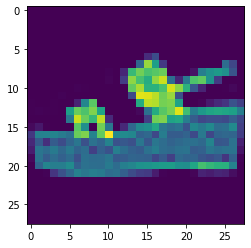

In [55]:
plt.imshow(X[12, :].reshape(28, 28))

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                    random_state = 123)

In [67]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# TODO: обучите случайный лес и kNN с дефолтными параметрами
# Сравните их доли правильных ответов на тестовой выборке
start = time.time()
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
print('RF:', time.time() - start)

start = time.time()
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
pred_knn = knn.predict(X_test)
print('kNN:', time.time() - start)

RF: 56.928375244140625
kNN: 45.91495418548584


In [65]:
accuracy_score(y_test, pred_rf)

0.8812222222222222

In [66]:
accuracy_score(y_test, pred_knn)

0.8505555555555555

#### 5.3 Тексты на примере бинарной классификации твитов из семинара 10

Скачиваем куски датасета ([источник](http://study.mokoron.com/)): [положительные](https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0), [отрицательные](https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv).

In [68]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MaxAbsScaler

# Предобработка из семинара 10
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = 'positive'
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = 'negative'
df = positive.append(negative)

X_train, X_test, y_train, y_test = train_test_split(df.text, df.label, random_state=13)

vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(X_train)
bow_test = vec.transform(X_test)

scaler = MaxAbsScaler()
bow = scaler.fit_transform(bow)
bow_test = scaler.transform(bow_test)

X_train = bow
X_test = bow_test

In [79]:
from sklearn.tree import DecisionTreeClassifier

# TODO: обучите случайный лес с числом деревьев 100 и макс. глубиной дерева 20 
# и решающее дерево с макс. глубиной 20
# Сравните их доли правильных ответов на тестовой выборке

start = time.time()
rf = RandomForestClassifier(max_depth=100)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
print('RF:', time.time() - start)

'''start = time.time()
dt = DecisionTreeClassifier(max_depth=20)
dt.fit(X_train, y_train)
pred_dt = dt.predict(X_test)
print('DT:', time.time() - start)'''

RF: 268.58561754226685


"start = time.time()\ndt = DecisionTreeClassifier(max_depth=20)\ndt.fit(X_train, y_train)\npred_dt = dt.predict(X_test)\nprint('DT:', time.time() - start)"

In [80]:
accuracy_score(y_test,  pred_rf)

0.7180518083549349

In [71]:
accuracy_score(y_test, pred_dt)

0.6278897529492673